In [1]:
# # Imports and settings
import pandas as pd
import duckdb
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import xgboost as xgb
import random
import os
import shap
from joblib import dump
from datetime import datetime
from pathlib import Path
from sklearn.metrics import mean_squared_error
from functools import reduce
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import log_loss
from tqdm import tqdm
from sklearn.metrics import brier_score_loss

pd.set_option('display.float_format', '{:.6f}'.format)
random_seed = 909
random.seed(random_seed)
np.random.seed(random_seed)

def select_features_correlation(X, correlation_threshold=0.8):
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X_numerical = X[numerical_cols]
    corr_matrix = X_numerical.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    X_reduced = X.drop(to_drop, axis=1)
    return X_reduced, to_drop

# Function to calculate profit based on bet and result
def calculate_profit(row, home_bet_col, away_bet_col):
    if row[home_bet_col] > 0:
        return row[home_bet_col] * (row['pp_ltp_home'] - 1.0) * (0.95) if row['winner_home'] == 1 else -row[home_bet_col]
    if row[away_bet_col] > 0:
        return row[away_bet_col] * (row['pp_ltp_away'] - 1.0) * (0.95) if row['winner_home'] == 0 else -row[away_bet_col]
    return 0.0

In [2]:
con = duckdb.connect("E:/duckdb/tennis.duckdb",read_only=True)
base_table = con.execute("SELECT * FROM base_table WHERE tournament_category IN ('ATP','Challenger','ITF Men')").df()
con.close()

In [3]:
target = 'winner_home'
# 
exclude_cols = ['matchup_indices', 'tournament_name', 'datetime','match_players','pp_ltp_home','pp_ltp_away','market_id','selection_id_home','selection_id_away', 'implied_prob_home']
time_split_col = 'yyyy'
cat_cols = ['groundType','tournament_category','tournament_points','tournament_round_category']
missing_match_stats_cols = ['backhandErrors','backhandUnforcedErrors','backhandWinners','dropShotUnforcedErrors','dropShotWinners','errorsTotal','forehandErrors','forehandUnforcedErrors','forehandWinners','groundstrokeErrors','groundstrokeUnforcedErrors','groundstrokeWinners','lobUnforcedErrors','lobWinners','overheadStrokeErrors','overheadWinners','pointsTotal','returnErrors','returnWinners','serviceGamesWon','unforcedErrorsTotal','volleyUnforcedErrors','volleyWinners','winnersTotal']
match_stat_cols = ['aces',	'backhandErrors',	'backhandUnforcedErrors',	'backhandWinners',	'breakPointsSaved',	'breakPointsScored',	'doubleFaults',	'dropShotUnforcedErrors',	'dropShotWinners',	'errorsTotal',	'firstReturnPoints',	'firstServeAccuracy',	'firstServePointsAccuracy',	'forehandErrors',	'forehandUnforcedErrors',	'forehandWinners',	'gamesWon',	'groundstrokeErrors',	'groundstrokeUnforcedErrors',	'groundstrokeWinners',	'lobUnforcedErrors',	'lobWinners',	'maxGamesInRow',	'maxPointsInRow',	'overheadStrokeErrors',	'overheadWinners',	'pointsTotal',	'receiverPointsScored',	'returnErrors',	'returnWinners',	'secondReturnPoints',	'secondServeAccuracy',	'secondServePointsAccuracy',	'serviceGamesTotal',	'serviceGamesWon',	'servicePointsScored',	'tiebreaks',	'unforcedErrorsTotal',	'volleyUnforcedErrors',	'volleyWinners',	'winnersTotal',	'breakPointsSavedAttempted',	'firstReturnPointsAttempted',	'firstServeAccuracyAttempted',	'firstServePointsAccuracyAttempted',	'secondReturnPointsAttempted',	'secondServeAccuracyAttempted',	'secondServePointsAccuracyAttempted']

base_table.drop(columns=missing_match_stats_cols,inplace=True)

for col in [x for x in match_stat_cols if x not in missing_match_stats_cols]:
    base_table[col] = pd.to_numeric(base_table[col])

In [4]:
# ## Data cleaning steps
base_table.loc[base_table['tournament_points'].isna(),'tournament_points'] = 0.0
base_table['tournament_points'] = base_table['tournament_points'].astype(int)

base_table = base_table.query('(winner == 1 and result == "WINNER") or (winner == 0 and result == "LOSER") or result.isna()')

In [5]:
# ## Extra columns (pre-features)
# # Bo5 or Bo3 indicator
# Number of games played, won (replace gamesWon), lost
score_columns = ['score_period1', 'score_period2', 'score_period3', 'score_period4', 'score_period5']
base_table['gamesWon'] = base_table[score_columns].sum(axis=1, skipna=True)
base_table['gamesPlayed'] = base_table.groupby('id')['gamesWon'].transform('sum')
base_table['gamesWonPct'] = base_table['gamesWon'] / base_table['gamesPlayed']
# First serve pct (firstServeAccuracy / firstServeAccuracyAttempted)
base_table['firstServePct'] = base_table['firstServeAccuracy'] / base_table['firstServeAccuracyAttempted']
# First serve points won pct (firstServePointsAccuracy / firstServeAccuracy)
base_table['firstServeWonPct'] = base_table['firstServePointsAccuracy'] / base_table['firstServeAccuracy']
# Second serve pct (secondServeAccuracy / secondServeAccuracyAttempted)
base_table['secondServePct'] = base_table['secondServeAccuracy'] / base_table['secondServeAccuracyAttempted']
# Second serve points won pct (secondServePointsAccuracy / secondServeAccuracy)
base_table['secondServeWonPct'] = base_table['secondServePointsAccuracy'] / base_table['secondServeAccuracy']
# Break points saved pct (breakPointsSaved / breakPointsSavedAttempted)
base_table['breakPointsSavedPct'] = base_table['breakPointsSaved'] / base_table['breakPointsSavedAttempted']
# Break points won pct (breakPointsScored / (breakPointsSaved_opponent + breakPointsScored))
# Assuming base_table is your DataFrame
base_table['breakPointsWonPct'] = base_table['breakPointsSaved'] / base_table.groupby('id')['breakPointsSaved'].transform('sum')

# Mens category
base_table['mens'] = base_table['tournament_category'].isin(['ATP', 'Challenger', 'ITF Men']).astype(int)

# Elo quartiles
base_table['elo_cat_ntile'] = base_table.groupby('mens')['pre_match_elo'].transform(lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop'))

base_table['doubleFaults_div_gamesPlayed'] = base_table['doubleFaults'] / base_table['gamesPlayed']
base_table['maxGamesInRow_div_gamesPlayed'] = base_table['maxGamesInRow'] / base_table['gamesPlayed']
base_table['gained_elo'] = base_table['post_match_elo'] - base_table['pre_match_elo']

In [6]:
# # Add opponent
# # Create opponent_index by merging the DataFrame with itself
opponent_df = base_table[['id', 'index']].merge(
    base_table[['id', 'index']],
    on='id',
    suffixes=('', '_opponent')
)
# Remove matches where index and index_opponent are the same
opponent_df = opponent_df[opponent_df['index'] != opponent_df['index_opponent']].drop_duplicates(['id', 'index'])

# Merge opponent_index back into base_table
base_table = base_table.merge(
    opponent_df[['id', 'index', 'index_opponent']],
    on=['id', 'index']
)

base_table['index_opponent'] = base_table['index_opponent'].astype(int)

# Create matchup_indices without using apply
min_index = base_table[['index', 'index_opponent']].min(axis=1).astype(str)
max_index = base_table[['index', 'index_opponent']].max(axis=1).astype(str)
base_table['matchup_indices'] = min_index + '|' + max_index

# Compute opponent's pre-match ELO
opponent_elo_df = base_table[['id', 'index', 'pre_match_elo']].rename(
    columns={'index': 'index_opponent', 'pre_match_elo': 'opponent_pre_match_elo'}
)
base_table = base_table.merge(
    opponent_elo_df,
    on=['id', 'index_opponent'],
    how='left'
)

# Calculate ELO differences
base_table['pre_match_elo_diff'] = base_table['pre_match_elo'] - base_table['opponent_pre_match_elo']
# Typical win rate at this elo diff
base_table['elo_diff_ntile'] = base_table.groupby('mens')['pre_match_elo_diff'].transform(lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop'))

In [7]:
# # Ensure the DataFrame is sorted by datetime
base_table.sort_values('datetime',inplace=True)

# Career W/L
base_table['career_wins'] = base_table.groupby('index')['winner'].cumsum().groupby(base_table['index']).shift(1).fillna(0)
base_table['career_matches'] = base_table.groupby('index').cumcount()
base_table['career_wl_pct'] = base_table['career_wins'] / base_table['career_matches']

# W/L on surface, tournament points, tournament category, tournament name
for column in ['groundType', 'tournament_points', 'tournament_round_category', 'tournament_name']:
    group = base_table.groupby(['index', column])
    wins_col = f'career_wins_{column}'
    matches_col = f'career_matches_{column}'
    wl_pct_col = f'career_wl_pct_{column}'
    gained_elo_col = f'career_gained_elo_{column}'
    pbp_mean_col = f'career_pbp_mean_{column}'
    pbp_min_col = f'career_pbp_min_{column}'
    pbp_max_col = f'career_pbp_max_{column}'
    pbp_std_col = f'career_pbp_std_{column}'

    base_table[wins_col] = group['winner'].cumsum().groupby([base_table['index'], base_table[column]]).shift(1).fillna(0)
    base_table[matches_col] = group.cumcount()
    base_table[wl_pct_col] = base_table[wins_col] / base_table[matches_col]
    base_table[gained_elo_col] = group['gained_elo'].cumsum().groupby([base_table['index'], base_table[column]]).shift(1).fillna(0)
    base_table[pbp_mean_col] = group['winrate_mean'].cumsum().groupby([base_table['index'], base_table[column]]).shift(1).fillna(0) / base_table[matches_col]
    base_table[pbp_min_col] = group['winrate_min'].cumsum().groupby([base_table['index'], base_table[column]]).shift(1).fillna(0) / base_table[matches_col]
    base_table[pbp_max_col] = group['winrate_max'].cumsum().groupby([base_table['index'], base_table[column]]).shift(1).fillna(0) / base_table[matches_col]
    base_table[pbp_std_col] = group['winrate_std'].cumsum().groupby([base_table['index'], base_table[column]]).shift(1).fillna(0) / base_table[matches_col]
    
base_table = base_table.copy()

In [8]:
# # Compute last matchup ELO difference and ratio
base_table['last_time_matchup_elo_diff'] = base_table.groupby(['index', 'matchup_indices'])['pre_match_elo_diff'].shift(1)
base_table['elo_diff_ratio_v_last'] = base_table['pre_match_elo_diff'] - base_table['last_time_matchup_elo_diff']

# Compute head-to-head statistics
group = base_table.groupby(['index', 'matchup_indices'])
base_table['h2h_opponent_wins'] = group['winner'].cumsum().groupby([base_table['index'], base_table['matchup_indices']]).shift(1).fillna(0)
base_table['h2h_opponent_matches'] = group.cumcount()
base_table['h2h_opponent_win_pct'] = base_table['h2h_opponent_wins'] / base_table['h2h_opponent_matches']
base_table['h2h_opponent_gained_elo'] = group['gained_elo'].cumsum().groupby([base_table['index'], base_table['matchup_indices']]).shift(1).fillna(0)
base_table['h2h_opponent_pbp_mean'] = group['winrate_mean'].cumsum().groupby([base_table['index'], base_table['matchup_indices']]).shift(1).fillna(0) / base_table['h2h_opponent_matches']
base_table['h2h_opponent_pbp_min'] = group['winrate_min'].cumsum().groupby([base_table['index'], base_table['matchup_indices']]).shift(1).fillna(0) / base_table['h2h_opponent_matches']
base_table['h2h_opponent_pbp_max'] = group['winrate_max'].cumsum().groupby([base_table['index'], base_table['matchup_indices']]).shift(1).fillna(0) / base_table['h2h_opponent_matches']
base_table['h2h_opponent_pbp_std'] = group['winrate_std'].cumsum().groupby([base_table['index'], base_table['matchup_indices']]).shift(1).fillna(0) / base_table['h2h_opponent_matches']

In [9]:
# # Compute W/L last 1, 3, 5, 10
wins_dict = {}
matches_dict = {}
wl_pct_dict = {}
elo_gain_dict = {}
pbp_mean_dict = {}
pbp_min_dict = {}
pbp_max_dict = {}
pbp_std_dict = {}

base_table.sort_values('datetime',inplace=True)
grouped_winner = base_table.groupby('index')

for window in [1, 3, 5, 10]:
    wins_col = f'last_{window}_wins'
    matches_col = f'last_{window}_matches'
    wl_pct_col = f'last_{window}_wl_pct'
    gained_elo_col = f'last_{window}_gained_elo'
    pbp_mean_col = f'last_{window}_pbp_mean'
    pbp_min_col = f'last_{window}_pbp_min'
    pbp_max_col = f'last_{window}_pbp_max'
    pbp_std_col = f'last_{window}_pbp_std'
    
    wins = grouped_winner['winner'].transform(lambda x: x.rolling(window=window, min_periods=1).sum().shift(1))
    matches = grouped_winner['winner'].transform(lambda x: x.rolling(window=window, min_periods=1).count().shift(1))
    wl_pct = wins / matches.replace(0, np.nan)
    gained_elo = grouped_winner['gained_elo'].transform(lambda x: x.rolling(window=window,min_periods=1).sum().shift(1))
    pbp_mean = grouped_winner['winrate_mean'].transform(lambda x: x.rolling(window=window,min_periods=1).sum().shift(1))
    pbp_min = grouped_winner['winrate_min'].transform(lambda x: x.rolling(window=window,min_periods=1).sum().shift(1))
    pbp_max = grouped_winner['winrate_max'].transform(lambda x: x.rolling(window=window,min_periods=1).sum().shift(1))
    pbp_std = grouped_winner['winrate_std'].transform(lambda x: x.rolling(window=window,min_periods=1).sum().shift(1))
    
    wins_dict[wins_col] = wins.fillna(0)
    matches_dict[matches_col] = matches.fillna(0)
    wl_pct_dict[wl_pct_col] = wl_pct.fillna(0)
    elo_gain_dict[gained_elo_col] = gained_elo
    pbp_mean_dict[pbp_mean_col] = pbp_mean
    pbp_min_dict[pbp_min_col] = pbp_min
    pbp_max_dict[pbp_max_col] = pbp_max
    pbp_std_dict[pbp_std_col] = pbp_std

# Assign all the new W/L columns at once
wl_columns = {**wins_dict, **matches_dict, **wl_pct_dict, **elo_gain_dict, **pbp_mean_dict, **pbp_min_dict, **pbp_max_dict, **pbp_std_dict}
base_table = base_table.assign(**wl_columns)

In [10]:
stats_to_roll_columns = ['doubleFaults_div_gamesPlayed','maxGamesInRow_div_gamesPlayed','receiverPointsScored','tiebreaks','gamesWonPct','firstServePct','firstServeWonPct','secondServePct','secondServeWonPct','breakPointsSavedPct','breakPointsWonPct']
# 
base_table.sort_values('datetime',inplace=True)
stats_df = pd.DataFrame(base_table[['index']+stats_to_roll_columns], index=base_table.index)

# Compute rolling means
grouped = stats_df.groupby('index')
rolling_means = grouped[stats_to_roll_columns].apply(
    lambda x: x.rolling(window=10, min_periods=1).mean().shift(1)
)
rolling_means = rolling_means.reset_index(level=0, drop=True)
rolling_means.columns = [f'mean_{col}_last_10' for col in rolling_means.columns]

# Assign combined stats to base_table at once
base_table = pd.concat([base_table, rolling_means], axis=1)

# Defragment the DataFrame to improve performance
base_table = base_table.copy()

In [11]:
base_table.sort_values('datetime',inplace=True)
# 
# First, calculate the cumulative sum for each group
base_table['wins_at_elo_diff'] = base_table.groupby(['index', 'elo_diff_ntile'])['winner'].cumsum()
# Then shift the cumsum by 1 and fill NaN values with 0
base_table['wins_at_elo_diff'] = base_table.groupby(['index', 'elo_diff_ntile'])['wins_at_elo_diff'].shift(1).fillna(0)

# First, calculate the cumulative sum for each group
base_table['matches_played_at_elo_diff'] = base_table.groupby(['index', 'elo_diff_ntile']).cumcount()

# First, calculate the cumulative sum for each group
base_table['win_rate_at_elo_diff'] = base_table['wins_at_elo_diff'] / base_table['matches_played_at_elo_diff']

In [12]:
# # TODO: Features for time since last match
# # TODO: Performance in same tournament features
# TODO: Current elo vs average tournament ELO

In [13]:
for col in stats_to_roll_columns:
    base_table[f'mean_{col}_elo_diff_and_ntile'] = base_table.groupby(['elo_cat_ntile', 'elo_diff_ntile'])[col].expanding().mean().reset_index(level=[0,1], drop=True)
    base_table[f'mean_{col}_elo_diff_and_ntile'] = base_table.groupby('index')[f'mean_{col}_elo_diff_and_ntile'].shift(1)

    base_table[f'mean_{col}_player'] = base_table.groupby('index')[col].expanding().mean().reset_index(level=[0,1], drop=True)
    base_table[f'mean_{col}_player'] = base_table.groupby('index')[f'mean_{col}_player'].shift(1)

    base_table[f'{col}_player_vs_elo_diff_and_ntile'] = base_table[f'mean_{col}_player'] / base_table[f'mean_{col}_elo_diff_and_ntile']

    base_table[f'mean_{col}_elo_diff'] = base_table.groupby(['elo_diff_ntile'])[col].expanding().mean().reset_index(level=[0,1], drop=True)
    base_table[f'mean_{col}_elo_diff'] = base_table.groupby('index')[f'mean_{col}_elo_diff'].shift(1)

    base_table[f'{col}_player_vs_elo_diff'] = base_table[f'mean_{col}_player'] / base_table[f'mean_{col}_elo_diff']

base_table = base_table.copy()

# Feature normalisation by ELO band
To-do: add feature normalisation by tournament points, ground type, etc

In [14]:
# # List of features
norm_features = (
    ['pre_match_elo', 'career_wins', 'career_matches', 'career_wl_pct',
                 'career_wins_groundType', 'career_matches_groundType', 'career_wl_pct_groundType','career_gained_elo_groundType','career_pbp_mean_groundType','career_pbp_min_groundType','career_pbp_max_groundType','career_pbp_std_groundType',
                 'career_wins_tournament_points', 'career_matches_tournament_points', 'career_wl_pct_tournament_points','career_gained_elo_tournament_points','career_pbp_mean_tournament_points','career_pbp_min_tournament_points','career_pbp_max_tournament_points','career_pbp_std_tournament_points',
                 'career_wins_tournament_round_category', 'career_matches_tournament_round_category', 'career_wl_pct_tournament_round_category','career_gained_elo_tournament_round_category','career_pbp_mean_tournament_round_category','career_pbp_min_tournament_round_category','career_pbp_max_tournament_round_category','career_pbp_std_tournament_round_category',
                 'career_wins_tournament_name', 'career_matches_tournament_name', 'career_wl_pct_tournament_name','career_gained_elo_tournament_name','career_pbp_mean_tournament_name','career_pbp_min_tournament_name','career_pbp_max_tournament_name','career_pbp_std_tournament_name',
                 'h2h_opponent_wins', 'h2h_opponent_matches', 'h2h_opponent_win_pct','h2h_opponent_gained_elo','h2h_opponent_pbp_mean','h2h_opponent_pbp_min','h2h_opponent_pbp_max','h2h_opponent_pbp_std',
                 'last_1_wins', 'last_1_matches', 'last_1_wl_pct', 'last_1_gained_elo', 'last_1_pbp_mean','last_1_pbp_min','last_1_pbp_max','last_1_pbp_std',
                 'last_3_wins', 'last_3_matches', 'last_3_wl_pct', 'last_3_gained_elo', 'last_3_pbp_mean','last_3_pbp_min','last_3_pbp_max','last_3_pbp_std',
                 'last_5_wins', 'last_5_matches', 'last_5_wl_pct', 'last_5_gained_elo', 'last_5_pbp_mean','last_5_pbp_min','last_5_pbp_max','last_5_pbp_std',
                 # 'last_10_wins', 'last_10_matches', 'last_10_wl_pct', 'last_10_gained_elo', 'last_10_pbp_mean','last_10_pbp_min','last_10_pbp_max','last_10_pbp_std',
     'elo_diff_ratio_v_last', 'last_time_matchup_elo_diff',
                 'win_rate_at_elo_diff', 'matches_played_at_elo_diff', 'wins_at_elo_diff'] + 
    [f'mean_{col}_last_10' for col in stats_to_roll_columns] +
    # [f'mean_{col}_elo_diff' for col in stats_to_roll_columns] +
    # [f'mean_{col}_elo_diff_and_ntile' for col in stats_to_roll_columns] +
    # [f'{col}_player_vs_elo_diff' for col in stats_to_roll_columns] +
    [f'{col}_player_vs_elo_diff_and_ntile' for col in stats_to_roll_columns]
)

# Sort the dataframe by grouping columns and datetime
base_table = base_table.sort_values(['elo_cat_ntile', 'mens', 'datetime'])

# Define the rolling window size (e.g., 500 matches)
rolling_window = 500

# Group the dataframe
grouped = base_table.groupby(['elo_cat_ntile', 'mens'])

# Compute rolling mean and std over norm_features
rolling_stats = grouped[norm_features].rolling(window=rolling_window, min_periods=1)

# Compute rolling mean and std
rolling_mean = rolling_stats.mean()
rolling_std = rolling_stats.std()

# Remove the grouping columns from the index to align with base_table
rolling_mean = rolling_mean.reset_index(level=['elo_cat_ntile', 'mens'], drop=True)
rolling_std = rolling_std.reset_index(level=['elo_cat_ntile', 'mens'], drop=True)

# Rename columns to indicate rolling computations
rolling_mean.columns = [f'{col}_rolling_mean' for col in rolling_mean.columns]
rolling_std.columns = [f'{col}_rolling_std' for col in rolling_std.columns]

# Concatenate the rolling statistics to base_table
base_table = pd.concat([base_table, rolling_mean, rolling_std], axis=1)

for col in norm_features:
    base_table[f'{col}_elo_pct_norm'] = (base_table[col] - base_table[f'{col}_rolling_mean']) / base_table[f'{col}_rolling_std']
    
base_table.drop(columns=[f'{x}_rolling_mean' for x in norm_features] + [f'{x}_rolling_std' for x in norm_features],inplace=True)

# Defragment the DataFrame to improve performance
base_table = base_table.copy()

C:\Users\Vlad\AppData\Local\Temp\ipykernel_22048\1353950921.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_table[f'{col}_elo_pct_norm'] = (base_table[col] - base_table[f'{col}_rolling_mean']) / base_table[f'{col}_rolling_std']
C:\Users\Vlad\AppData\Local\Temp\ipykernel_22048\1353950921.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_table[f'{col}_elo_pct_norm'] = (base_table[col] - base_table[f'{col}_rolling_mean']) / base_table[f'{col}_rolling_std']


In [15]:
# base_table_model = base_table
# con = duckdb.connect("E:/duckdb/tennis.duckdb")
# con.execute("CREATE TABLE model_table AS SELECT * FROM base_table_model").df()
# con.close()

In [16]:
# prices_df = pd.read_csv("../../data/price_file.csv")
# prices_df['market_id'] = prices_df['market_id'].astype(str).str.pad(9, fillchar='0', side='right')

# Pivot home and away into single row

In [17]:
features_to_pivot = ['winner','clean_name','pp_ltp','selection_id'] + norm_features + [f'{x}_elo_pct_norm' for x in norm_features]
match_cols = ['market_id','matchup_indices','tournament_name','datetime','groundType','tournament_category','tournament_points','tournament_round_category']

home_df = base_table[base_table['position'] == 'home'].copy()
away_df = base_table[base_table['position'] == 'away'].copy()

# Step 2: Rename columns for home and away
home_columns = {col: f'{col}_home' for col in features_to_pivot}
away_columns = {col: f'{col}_away' for col in features_to_pivot}

home_df = home_df.rename(columns=home_columns)
away_df = away_df.rename(columns=away_columns)

# Step 3: Set index for merging
home_df.set_index('id', inplace=True)
away_df.set_index('id', inplace=True)

# Step 4: Merge home and away data
merged_df = pd.merge(home_df[list(home_columns.values())], away_df[list(away_columns.values())], left_index=True, right_index=True)
match_cols_df = base_table[['id'] + match_cols].drop_duplicates()
match_cols_df.set_index('id',inplace=True)

In [18]:
base_table_pivoted = merged_df.merge(match_cols_df, left_index=True, right_index=True)
base_table_pivoted['match_players'] = base_table_pivoted['clean_name_home'] + ' v ' + base_table_pivoted['clean_name_away']
base_table_pivoted.drop(columns=['winner_away','clean_name_home','clean_name_away'], inplace=True) # winner_home is the target

In [19]:
# # Create a list of columns to exclude
exclude_cols_pivot = ['winner', 'clean_name', 'pp_ltp','selection_id']

# Collect new columns in a dictionary
new_columns = {}

for col in [x for x in features_to_pivot if x not in exclude_cols_pivot]:
    if col == 'pre_match_elo':
        new_col_name = f'{col}_diff'
        new_col_values = base_table_pivoted[f'{col}_home'] - base_table_pivoted[f'{col}_away']
    else:
        new_col_name = f'{col}_ha_ratio'
        new_col_values = base_table_pivoted[f'{col}_home'] / base_table_pivoted[f'{col}_away']
    new_columns[new_col_name] = new_col_values

# Create 'yyyymm' and 'yyyy' columns
new_columns['yyyymm'] = (
    base_table_pivoted['datetime'].dt.year * 100 + base_table_pivoted['datetime'].dt.month
).astype(int)
new_columns['yyyy'] = base_table_pivoted['datetime'].dt.year.astype(int)

# Assign all new columns to base_table_pivoted at once
base_table_pivoted = base_table_pivoted.assign(**new_columns)

# Replace inf and -inf with NaN
base_table_pivoted.replace([np.inf, -np.inf], np.nan, inplace=True)

# Defragment the DataFrame to improve performance
base_table_pivoted = base_table_pivoted.copy()

# Convert columns in cat_cols to 'category' dtype
for col in cat_cols:
    if base_table_pivoted[col].dtype != int:
        base_table_pivoted.loc[base_table_pivoted[col].isna(),col] = "Unknown"
base_table_pivoted[cat_cols] = base_table_pivoted[cat_cols].astype('category')

base_table_pivoted['implied_prob_home'] = 1 / base_table_pivoted['pp_ltp_home'] 

C:\Users\Vlad\AppData\Local\Temp\ipykernel_22048\3097468481.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_table_pivoted = base_table_pivoted.assign(**new_columns)
C:\Users\Vlad\AppData\Local\Temp\ipykernel_22048\3097468481.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_table_pivoted = base_table_pivoted.assign(**new_columns)
C:\Users\Vlad\AppData\Local\Temp\ipykernel_22048\3097468481.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

In [20]:
base_table_bf_only = base_table_pivoted.dropna(subset=['market_id']).copy()
all_feature_cols = [x for x in base_table_bf_only.columns if x not in [target] + exclude_cols + [time_split_col] + ['yyyymm']]
non_cat_feature_cols = [x for x in all_feature_cols if x not in cat_cols]

non_datetime_cols = base_table_bf_only[all_feature_cols].select_dtypes(exclude=['datetime', 'datetime64','object','category']).columns
low_variance_cols = base_table_bf_only[non_datetime_cols].var()[base_table_bf_only[non_datetime_cols].var() <= 0].index
high_null_cols = base_table_bf_only[all_feature_cols].columns[base_table_bf_only[all_feature_cols].isnull().mean() > 0.95]

base_table_bf_only = base_table_bf_only.drop(columns=high_null_cols.tolist()+low_variance_cols.tolist())

In [21]:
all_feature_cols = [x for x in all_feature_cols if x not in high_null_cols.tolist()+low_variance_cols.tolist()]

In [33]:
base_table_bf_only = base_table_bf_only.sort_values('datetime')

slice_size = 10000

# Total rows in the DataFrame
total_rows = len(base_table_bf_only)

# Number of rows that don't fit evenly into slices of 20000
remainder = total_rows % slice_size

# The first slice will include the remainder (uneven portion)
first_slice_size = remainder if remainder > 0 else slice_size

# Create a list of slice numbers for the "DataFrame
slices = [0] * first_slice_size  # The first slice
slices += [(i // slice_size) + 1 for i in range(total_rows - first_slice_size)]  # Remaining slices in groups of 20000

# Add the slice number as a new column to the DataFrame
base_table_bf_only['slice'] = slices

# Run model

In [34]:
xgb_params_dict = {
    'outcome_brier': {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'device': 'cuda',
        'tree_method': 'hist',
        'eta': 0.026703061421157793,
        'max_depth': 5,
        'subsample': 0.6132797697262885,
        'colsample_bylevel': 0.7284484837154618,
        'colsample_bytree': 0.8737032287944834,
        'gamma': 3.194503518721281e-06,
        'lambda': 9.426795089012578e-05,
        'alpha': 0.00023960661999075894,
        'n_iterations': 680
    },
    'outcome_overfit': {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'device': 'cuda',
        'tree_method': 'hist',
        'eta': 0.05,
        'max_depth': 15,
        'subsample': 0.85,
        'colsample_bylevel': 0.5,
        'colsample_bytree': 0.9,
        'n_iterations': 1000
    },
    'price': {
        'objective': 'reg:logistic',
        'eval_metric': 'rmse',
        'device': 'cuda',
        'tree_method': 'hist',
        'eta': 0.04564606420838923,
        'max_depth': 5,
        'subsample': 0.6453507200852489,
        'colsample_bylevel': 0.8151947844055153,
        'colsample_bytree': 0.857479930482938,
        'gamma': 0.005108631599524818,
        'lambda': 1.7638886270274383e-07,
        'alpha': 0.0029574432594942053,
        'n_iterations': 890
    },
    'adversarial': {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'device': 'cuda',
        'tree_method': 'hist',
        'eta': 0.1,
        'max_depth': 4,
        'subsample': 0.8,
        'n_iterations': 300
    }
}
lgb_params_dict = {
    'outcome_brier': {
        'objective': 'binary',  # Change to binary classification
        'boosting_type': 'gbdt',  # LightGBM's boosting method (similar to XGBoost)
        'max_depth': 10, 
        'learning_rate': 0.027652453464663572, 
        'num_leaves': 126, 
        'feature_fraction': 0.5234594047477229,
        'bagging_fraction': 0.9864148504569701, 
        'bagging_freq': 12, 
        'min_child_samples': 23, 
        'lambda_l1': 0.01983775136876094, 
        'lambda_l2': 5.720450605222268, 
        'n_iter': 886,
        'device': 'gpu',  # Keep GPU training
        'verbose': -1
    }
    # 'outcome_overfit': {
    #     
    # },
    # 'price_logloss': {
    #     
    # }
}
cat_params_dict = {
    'outcome_brier': {
        'loss_function': 'Logloss',  # Change to binary classification (Logloss = binary:logistic)
        'eval_metric': 'Logloss',  # Match XGBoost's logloss eval metric
        'task_type': 'GPU',  # Keep GPU training
        'learning_rate': 0.04466999578305395,  # Match XGBoost's eta
        'depth': 7,  # Match XGBoost's max_depth
        'l2_leaf_reg': 0.0069139542652064965,  # Match XGBoost's lambda
        'subsample': 0.996337479485802,  # Match XGBoost's subsample
        'min_child_samples': 95,  # Use a similar value for min_child_samples
        'leaf_estimation_method': 'Newton',  # Keep Newton method
        'bootstrap_type': 'Bernoulli',  # Keep Bernoulli bootstrap
        'max_bin': 254,  # Keep max_bin (CatBoost's binning)
        'grow_policy': 'SymmetricTree',  # Keep grow policy
        'verbose': 0,
        'gpu_ram_part': 0.95,
        'iterations': 937
    },
    'outcome_overfit': {
        'loss_function': 'Logloss',  # Change to binary classification (Logloss = binary:logistic)
        'eval_metric': 'Logloss',  # Match XGBoost's logloss eval metric
        'task_type': 'GPU',  # Keep GPU training
        'learning_rate': 0.22804327839280975,  # Match XGBoost's eta
        'depth': 7,  # Match XGBoost's max_depth
        'l2_leaf_reg': 0.048701835136431025,  # Match XGBoost's lambda
        'subsample': 0.6551152672878527,  # Match XGBoost's subsample
        'min_child_samples': 75,  # Use a similar value for min_child_samples
        'leaf_estimation_method': 'Newton',  # Keep Newton method
        'bootstrap_type': 'Bernoulli',  # Keep Bernoulli bootstrap
        'max_bin': 254,  # Keep max_bin (CatBoost's binning)
        'grow_policy': 'SymmetricTree',  # Keep grow policy
        'verbose': 0,
        'gpu_ram_part': 0.95,
        'iterations': 1065
    },
    'price': {
        'loss_function': 'RMSE',  # Change to binary classification (Logloss = binary:logistic)
        'eval_metric': 'RMSE',  # Match XGBoost's logloss eval metric
        'task_type': 'GPU',  # Keep GPU training
        'learning_rate': 0.04466999578305395,  # Match XGBoost's eta
        'depth': 7,  # Match XGBoost's max_depth
        'l2_leaf_reg': 0.0069139542652064965,  # Match XGBoost's lambda
        'subsample': 0.996337479485802,  # Match XGBoost's subsample
        'min_child_samples': 95,  # Use a similar value for min_child_samples
        'leaf_estimation_method': 'Newton',  # Keep Newton method
        'bootstrap_type': 'Bernoulli',  # Keep Bernoulli bootstrap
        'max_bin': 254,  # Keep max_bin (CatBoost's binning)
        'grow_policy': 'SymmetricTree',  # Keep grow policy
        'verbose': 0,
        'gpu_ram_part': 0.95,
        'iterations': 937
    }
}

In [35]:
# Models to train
configs = [
    { # Standard model
        'name': 'standard',
        'hyperparameter_set': 'outcome_brier',
        'run_xgb': True,
        'run_lgb': True,
        'run_cb': False,
        'repeat_iterations': 1,
        'target_col': 'winner_home',
        'features': all_feature_cols
    },
    { # Good price prediction model
        'name': 'price',
        'hyperparameter_set': 'price',
        'run_xgb': True,
        'run_lgb': False,
        'run_cb': False,
        'repeat_iterations': 1,
        'target_col': 'implied_prob_home',
        'features': all_feature_cols
    },
    { # Simplistic adversarial model
        'name': 'adv',
        'hyperparameter_set': 'adversarial',
        'run_xgb': True,
        'run_lgb': False,
        'run_cb': False,
        'repeat_iterations': 1,
        'target_col': 'winner_home',
        'features': all_feature_cols,
        'feature_selection': {
            'type': 'correlation',
            'n_features': 10
        }
    },
    { # Overfit outcome model
        'name': 'of',
        'hyperparameter_set': 'outcome_overfit',
        'run_xgb': True,
        'run_lgb': False,
        'run_cb': False,
        'repeat_iterations': 1,
        'target_col': 'winner_home',
        'features': all_feature_cols
    },
    { # Standard model
        'name': 'standard_rfs',
        'hyperparameter_set': 'outcome_brier',
        'run_xgb': True,
        'run_lgb': True,
        'run_cb': False,
        'repeat_iterations': 5,
        'target_col': 'winner_home',
        'features': all_feature_cols,
        'feature_selection': {
            'type': 'random',
            'n_features': 100
        }
    }
    # { # Standard model
    #     'name': 'standard_orth',
    #     'hyperparameter_set': 'outcome_brier',
    #     'run_xgb': True,
    #     'run_lgb': True,
    #     'run_cb': True,
    #     'repeat_iterations': 1,
    #     'target_col': 'winner_home',
    #     'features': all_feature_cols,
    #     'feature_selection': {
    #         'type': 'orthogonal',
    #         'n_features': 50
    #     }
    # },
    # { # Good price prediction model
    #     'name': 'price_orth',
    #     'hyperparameter_set': 'price',
    #     'run_xgb': True,
    #     'run_lgb': False,
    #     'run_cb': False,
    #     'repeat_iterations': 1,
    #     'target_col': 'implied_prob_home',
    #     'features': all_feature_cols,
    #     'feature_selection': {
    #         'type': 'orthogonal',
    #         'n_features': 50
    #     }
    # }
]

In [36]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import spearmanr

def nan_safe_mutual_info(X, y):
    """Calculate mutual information, ignoring NaN values."""
    mi_scores = []
    for column in X.columns:
        # Create a mask for non-NaN values
        mask = ~X[column].isna() & ~y.isna()
        if mask.sum() > 0:  # Only calculate if there are non-NaN values
            mi = mutual_info_classif(X[column].values[mask].reshape(-1, 1), y[mask])[0]
        else:
            mi = 0  # Assign zero mutual information if all values are NaN
        mi_scores.append(mi)
    return np.array(mi_scores)

def nan_safe_correlation(x, y):
    """Calculate Spearman correlation, ignoring NaN values."""
    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() > 1:  # Need at least 2 non-NaN values to calculate correlation
        return abs(spearmanr(x[mask], y[mask])[0])
    return 0  # Return 0 correlation if not enough non-NaN values

def select_features(config, all_features, X_train, y_train):
    if 'feature_selection' not in config:
        return all_features
    
    selection_type = config['feature_selection']['type']
    n_features = config['feature_selection']['n_features']
    
    # Separate numeric and categorical features
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = [f for f in all_features if f not in numeric_features]
    
    if selection_type == 'random':
        selected_numeric = np.random.choice(numeric_features, min(n_features, len(numeric_features)), replace=False)
    
    elif selection_type == 'orthogonal':
        # Orthogonal selection using mutual information for numeric features
        X_numeric = X_train[numeric_features]
        mi_scores = nan_safe_mutual_info(X_numeric, y_train)
        sorted_features = [x for _, x in sorted(zip(mi_scores, numeric_features), reverse=True)]
        selected_numeric = [sorted_features[0]]
        
        for feature in sorted_features[1:]:
            if len(selected_numeric) >= n_features:
                break
            # Check if the feature is sufficiently different from already selected features
            if all(nan_safe_correlation(X_numeric[feature], X_numeric[f]) < 0.7 for f in selected_numeric):
                selected_numeric.append(feature)
    
    elif selection_type == 'correlation':
        # Select numeric features most correlated with the target
        correlations = []
        for feature in numeric_features:
            corr = nan_safe_correlation(X_train[feature], y_train)
            correlations.append((feature, corr))
        
        # Sort features by correlation and select top n_features
        sorted_features = sorted(correlations, key=lambda x: x[1], reverse=True)
        selected_numeric = [f[0] for f in sorted_features[:n_features]]
    
    else:
        raise ValueError(f"Unknown feature selection type: {selection_type}")
    
    # Combine selected numeric features with all categorical features
    return list(selected_numeric) + categorical_features

In [26]:
# del base_table
# del base_table_pivoted
# import gc
# gc.collect()

0

In [37]:
# Run model
model_id = f'{datetime.now().strftime("%Y%m%d_%H%M%S")}'
dirname = f"../outputs/{model_id}"
os.makedirs(dirname)

## PARAMS
time_split_col = 'slice'
num_folds = 4

## RUN
folds = base_table_bf_only.sort_values('datetime')[time_split_col].unique()[-num_folds:]
output_price_dfs = []

for config in configs:
    print(f"Training config: {config['name']}")
    os.mkdir(f'{dirname}/{config['name']}')
    repeat_iterations = config['repeat_iterations']
    run_xgb = config['run_xgb']
    run_lgb = config['run_lgb']
    run_cb = config['run_cb']
    target = config['target_col']
    features = config['features']
    
    df_train = base_table_bf_only[~base_table_bf_only[target].isna()].copy()
    
    # Initialize models list and predictions array
    models = []
    fold_metrics = []
    validation_predictions = []
    
    # Existing code for all folds (2019-2023)
    for fold, val_fold in enumerate(folds, 1):
        print(f" Fold {fold} - {val_fold}")
    
        # Split data
        train_mask = df_train[time_split_col] < val_fold
        val_mask = df_train[time_split_col] == val_fold
    
        X_fold_train, y_fold_train = df_train[train_mask][features], df_train[train_mask][target]
        X_val, y_val = df_train[val_mask][features], df_train[val_mask][target]
    
        if len(X_val) == 0:
            continue
    
        # Select features
        selected_features = select_features(config, features, X_fold_train, y_fold_train)
        X_fold_train = X_fold_train[selected_features]
        X_val = X_val[selected_features]
    
        df_val = df_train[val_mask].copy()
    
        for i in range(repeat_iterations):
            print(f"  Iteration {i+1}")
            
            if run_xgb:
                print("   Training XGBoost")
                
                dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train, feature_names=selected_features, enable_categorical=True)
                dval = xgb.DMatrix(X_val, feature_names=selected_features, enable_categorical=True)

                xgb_params = xgb_params_dict[config['hyperparameter_set']].copy()
                num_xgb_iterations = xgb_params.pop('n_iterations')
                xgb_params_with_seed = {**xgb_params, 'seed': random_seed+i}
                
                xgb_model = xgb.train(xgb_params_with_seed, dtrain, num_boost_round=num_xgb_iterations, evals=[(dtrain,'train')], verbose_eval=False)
                df_val[f'prediction_xgb_{config['name']}_{i}'] = xgb_model.predict(dval)
                
                models.append(
                    {
                        'config': config['name'],
                        'hyperparameters': {**xgb_params_with_seed, 'n_iterations': num_xgb_iterations},
                        'model_type': 'xgb',
                        'fold': val_fold,
                        'iteration': i,
                        'model': xgb_model
                    }
                )
    
            if run_lgb:
                print("   Training LightGBM")
                lgb_train_data = lgb.Dataset(X_fold_train, label=y_fold_train, categorical_feature=cat_cols)

                lgb_params = lgb_params_dict[config['hyperparameter_set']]
                lgb_params_with_seed = {**lgb_params, 'seed': random_seed+i}
                
                lgb_model = lgb.train(lgb_params_with_seed, lgb_train_data)
                df_val[f'prediction_lgb_{config['name']}_{i}'] = lgb_model.predict(X_val)
                
                models.append(
                    {
                        'config': config['name'],
                        'hyperparameters': lgb_params_with_seed,
                        'model_type': 'lgb',
                        'fold': val_fold,
                        'iteration': i,
                        'model': lgb_model
                    }
                )
    
            if run_cb:
                print("   Training CatBoost")

                cat_params = cat_params_dict[config['hyperparameter_set']]
                cat_params_with_seed = {**cat_params, 'random_seed': random_seed+i}
                
                if config['name'] == 'price_pred':
                    cat_model = CatBoostRegressor(**cat_params_with_seed)
                    cat_model.fit(
                        Pool(X_fold_train, label=y_fold_train, cat_features=cat_cols),
                        verbose=False
                    )
                    df_val[f'prediction_cat_{config['name']}_{i}'] = cat_model.predict(X_val)
                else:
                    cat_model = CatBoostClassifier(**cat_params_with_seed)
                    cat_model.fit(
                        Pool(X_fold_train, label=y_fold_train, cat_features=cat_cols),
                        verbose=False
                    )
                    df_val[f'prediction_cat_{config['name']}_{i}'] = cat_model.predict_proba(X_val)[:,1]
                
                models.append(
                    {
                        'config': config['name'],
                        'hyperparameters': cat_params_with_seed,
                        'model_type': 'cat',
                        'fold': val_fold,
                        'iteration': i,
                        'model': cat_model
                    }
                )
    
        # Calculate average prediction for each model type and parameter set
        for model_type in ['xgb', 'lgb', 'cat']:
            if (model_type == 'xgb' and run_xgb) or (model_type == 'lgb' and run_lgb) or (model_type == 'cat' and run_cb):
                cols = [col for col in df_val.columns if col.startswith(f'prediction_{model_type}_')]
                df_val[f'prediction_{model_type}_{config['name']}_avg'] = df_val[cols].mean(axis=1)
    
        # Calculate overall prediction (average of all models)
        prediction_cols = [col for col in df_val.columns if col.startswith('prediction_') and not col.endswith('_avg')]
        df_val['prediction'] = df_val[prediction_cols].mean(axis=1)
        
        # Filter Betfair data and create predicted prices
        betfair_only = df_val.dropna(subset=['market_id']).copy()
        
        if config['name'] == 'price':
            metric = mean_squared_error(betfair_only[target], betfair_only['prediction'])
            
            fold_metrics.append({
                'fold': val_fold,
                'config': config,
                'error': metric,
                'error_type': 'mse',
                'num_matches': len(betfair_only)
            })
        else:
            metric = brier_score_loss(betfair_only[target], betfair_only['prediction'])
        
            fold_metrics.append({
                'fold': val_fold,
                'config': config,
                'error': metric,
                'error_type': 'brier_score',
                'num_matches': len(betfair_only)
            })
    
        validation_predictions.append({
            'val': df_val,
            'bf_only': betfair_only
        })
        
        print(f" Config: {config['name']} | Fold: {val_fold} | Error: {metric:.5f}")
    
    all_val_error = sum([x['error'] * x['num_matches'] for x in fold_metrics]) / sum([x['num_matches'] for x in fold_metrics])
    
    # Combine all validation predictions
    all_predictions = pd.concat([vp['val'] for vp in validation_predictions])
    all_betfair = pd.concat([vp['bf_only'] for vp in validation_predictions])
    
    print(f'Config: {config['name']} | Overall | Error: {all_val_error:.5f}')
    
    # Add to output price DFs list
    output_price_dfs.append(all_betfair[['market_id','selection_id_home','selection_id_away','tournament_category','tournament_points'] + [x for x in all_betfair.columns if x.startswith('prediction_')]])
    
    # Save predictions
    all_predictions.to_csv(f"{dirname}/{config['name']}/all_predictions.csv", index=False)
    all_betfair.to_csv(f"{dirname}/{config['name']}/all_betfair_predictions.csv", index=False)
    
    # Save metrics
    pd.DataFrame(fold_metrics).to_csv(f"{dirname}/{config['name']}/fold_metrics.csv", index=False)
    
    # Save models, validation, feature_importance
    dump(models, f"{dirname}/{config['name']}/models.joblib")
    
result_df = reduce(lambda left, right: pd.merge(left, right, on=['market_id','selection_id_home','selection_id_away','tournament_category','tournament_points'], how='outer'), output_price_dfs)
result_df.to_csv(f"{dirname}/simulation_file.csv", index=False)

Training config: standard
 Fold 1 - 5
  Iteration 1
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


 Config: standard | Fold: 5 | Error: 0.21048
 Fold 2 - 6
  Iteration 1
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


 Config: standard | Fold: 6 | Error: 0.20767
 Fold 3 - 7
  Iteration 1
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


 Config: standard | Fold: 7 | Error: 0.21435
 Fold 4 - 8
  Iteration 1
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


 Config: standard | Fold: 8 | Error: 0.20918
Config: standard | Overall | Error: 0.21042
Training config: price
 Fold 1 - 5
  Iteration 1
   Training XGBoost
 Config: price | Fold: 5 | Error: 0.00924
 Fold 2 - 6
  Iteration 1
   Training XGBoost
 Config: price | Fold: 6 | Error: 0.00804
 Fold 3 - 7
  Iteration 1
   Training XGBoost
 Config: price | Fold: 7 | Error: 0.00707
 Fold 4 - 8
  Iteration 1
   Training XGBoost
 Config: price | Fold: 8 | Error: 0.00748
Config: price | Overall | Error: 0.00794
Training config: adv
 Fold 1 - 5
  Iteration 1
   Training XGBoost
 Config: adv | Fold: 5 | Error: 0.21489
 Fold 2 - 6
  Iteration 1
   Training XGBoost
 Config: adv | Fold: 6 | Error: 0.21120
 Fold 3 - 7
  Iteration 1
   Training XGBoost
 Config: adv | Fold: 7 | Error: 0.21519
 Fold 4 - 8
  Iteration 1
   Training XGBoost
 Config: adv | Fold: 8 | Error: 0.21280
Config: adv | Overall | Error: 0.21352
Training config: of
 Fold 1 - 5
  Iteration 1
   Training XGBoost
 Config: of | Fold: 5 | E

E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 2
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 3
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 4
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 5
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


 Config: standard_rfs | Fold: 5 | Error: 0.21386
 Fold 2 - 6
  Iteration 1
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 2
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 3
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 4
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 5
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


 Config: standard_rfs | Fold: 6 | Error: 0.21632
 Fold 3 - 7
  Iteration 1
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 2
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 3
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 4
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 5
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


 Config: standard_rfs | Fold: 7 | Error: 0.21557
 Fold 4 - 8
  Iteration 1
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 2
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 3
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 4
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  Iteration 5
   Training XGBoost
   Training LightGBM


E:\Kaggle\bf-brownlow-2024\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


 Config: standard_rfs | Fold: 8 | Error: 0.21569
Config: standard_rfs | Overall | Error: 0.21536


In [38]:
model_id

'20241021_161003'

# Archive

CSV: 20241019_094247
Total Markets Bet: 9281
Total Matched: $79839.37 | Total Profit: $-4815.38 | Simulated POT: -6.031%


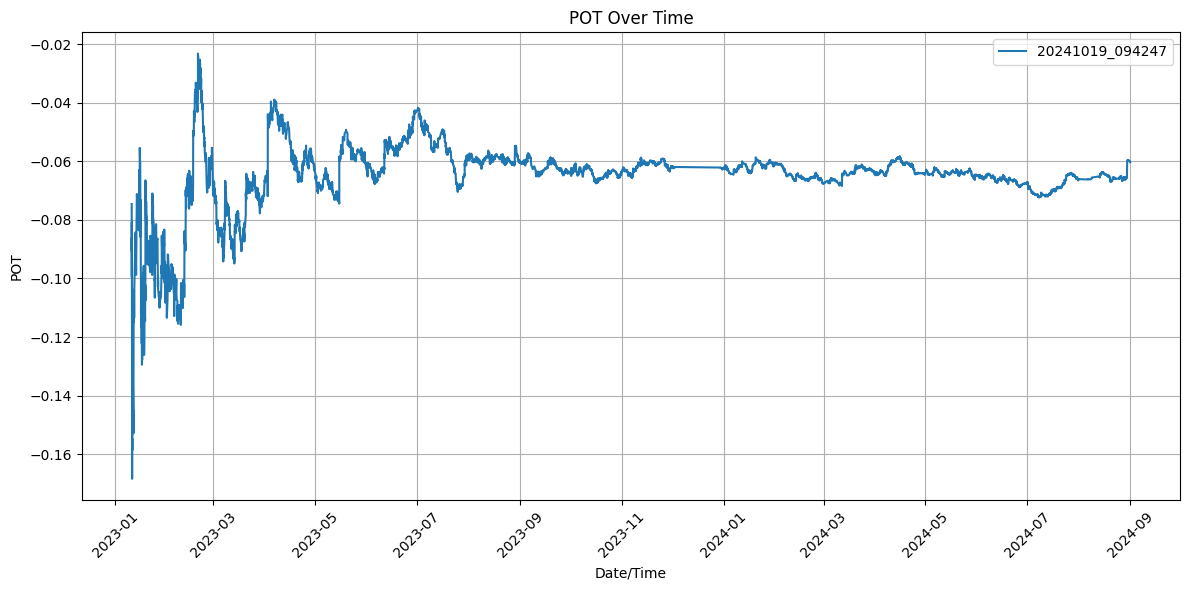

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

def process_csv(dirname):
    simulation_results = pd.read_csv(f'../../simulation/outputs/{dirname}.csv')
    simulation_results['date_time_placed'] = pd.to_datetime(simulation_results['date_time_placed'], format='mixed')
    simulation_results = simulation_results.sort_values(by='date_time_placed')

    simulation_results['profit_minus_commission'] = simulation_results['profit']
    simulation_results.loc[simulation_results['profit'] > 0,'profit_minus_commission'] = simulation_results['profit'] * (1 - 0.05)
    simulation_results['cumulative_profit'] = simulation_results['profit_minus_commission'].cumsum()

    simulation_results['total_matched_cum'] = simulation_results['size_matched'].cumsum()
    simulation_results['total_orders'] = range(len(simulation_results))
    # simulation_results
    simulation_results['pot'] = simulation_results['cumulative_profit'] / simulation_results['total_matched_cum']

    total_markets_bet = len(simulation_results['market_id'].unique())
    total_profit = simulation_results['profit_minus_commission'].sum()
    total_matched = simulation_results['size_matched'].sum()
    pot = total_profit / total_matched
    print(f"CSV: {dirname}")
    print(f"Total Markets Bet: {total_markets_bet}")
    print(f"Total Matched: ${total_matched:.2f} | Total Profit: ${total_profit:.2f} | Simulated POT: {pot*100:.3f}%")
    
    return simulation_results.query('total_orders > 100')

csv_names = [model_id]#, f'{model_id}ev0', f'{model_id}ev003', f'{model_id}evbt0_003', f'{model_id}evbt0005_004']

plt.figure(figsize=(12, 6))

for csv_name in csv_names:
    results = process_csv(csv_name)
    plt.plot(results['date_time_placed'], results['pot'], label=csv_name)


plt.title('POT Over Time')
plt.xlabel('Date/Time')
plt.ylabel('POT')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

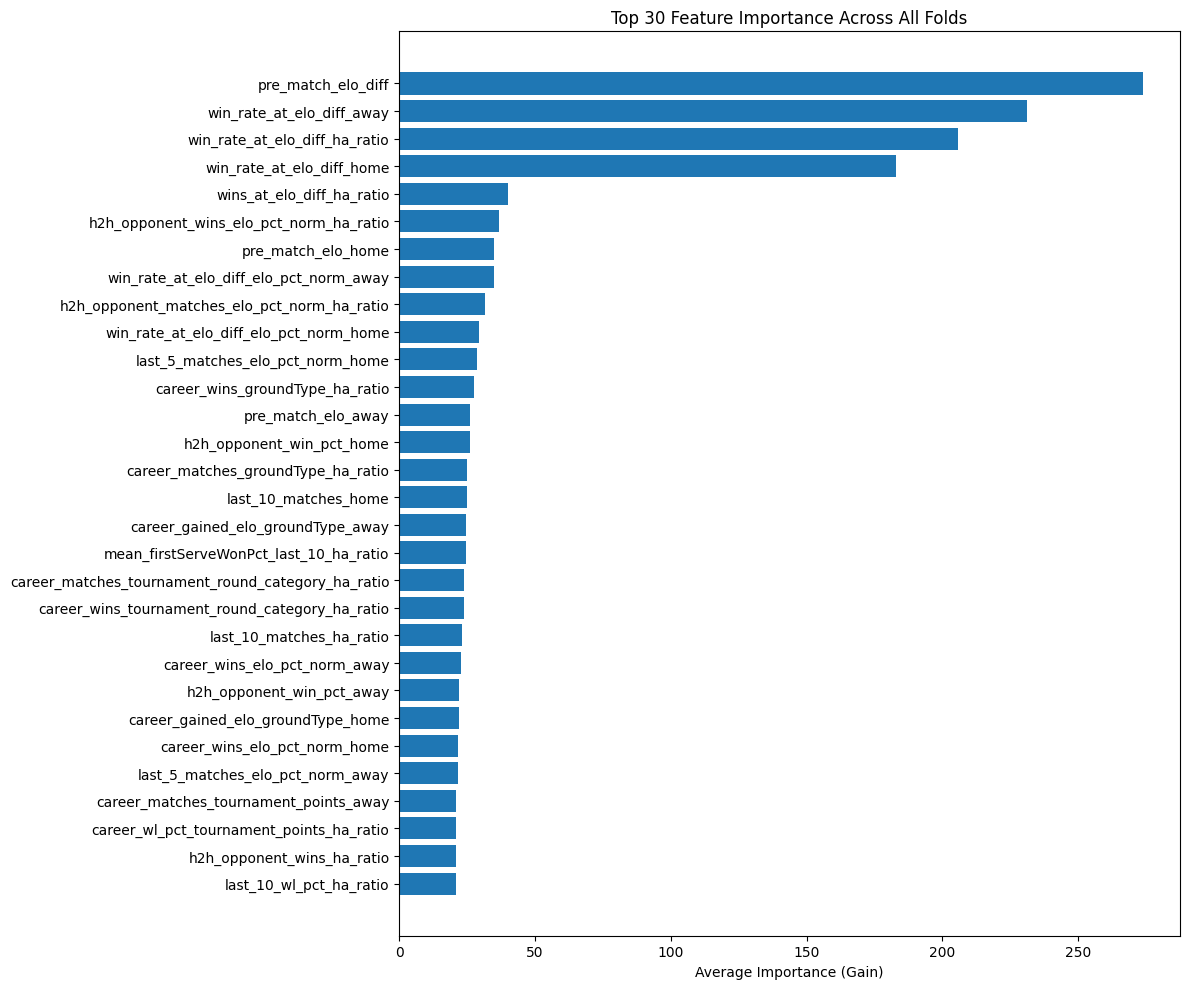

In [186]:

# # Calculate feature importance for each model
feature_importance_list = []
for model_info in models:
    xgb_model = model_info['model']
    feature_importance = xgb_model.get_score(importance_type='gain')
    feature_importance_list.append(feature_importance)

# Calculate average feature importance across all models
avg_feature_importance = {}
for feature in all_feature_cols:
    avg_feature_importance[feature] = np.mean([fold_importance.get(feature, 0) for fold_importance in feature_importance_list])

# Sort features by importance
sorted_features = sorted(avg_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Create a horizontal bar chart of feature importance
plt.figure(figsize=(12, 10))
features, importance = zip(*sorted_features[:30])  # Get top 20 features
y_pos = np.arange(len(features))

plt.barh(y_pos, importance)
plt.yticks(y_pos, features)
plt.xlabel('Average Importance (Gain)')
plt.title('Top 30 Feature Importance Across All Folds')
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature at the top
plt.tight_layout()
plt.show()

# Optuna

In [ ]:
import optuna
def objective(trial):
    # CatBoost parameters
    cat_params = {
        'loss_function': 'Logloss',  # Change to binary classification (Logloss = binary:logistic)
        'eval_metric': 'Logloss',  # Match XGBoost's logloss eval metric
        'task_type': 'GPU',
        'random_seed': random_seed,

        # Hyperparameters to optimize
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),

        # Other parameters
        'leaf_estimation_method': 'Newton',
        'bootstrap_type': 'Bernoulli',
        'max_bin': 254,  # Must be less than 256 for GPU
        'grow_policy': 'SymmetricTree',
        'verbose': 0,
        'gpu_ram_part': 0.95,
    }

    # Number of iterations
    n_iterations = trial.suggest_int('n_iterations', 300, 1300)

    fold_metrics = []
    validation_predictions = []

    # Existing code for all folds (2019-2023)
    for fold, val_fold in enumerate(folds, 1):
        print(f"Fold {fold} - {val_fold}")

        # Split data
        train_mask = df_train[time_split_col] < val_fold
        val_mask = df_train[time_split_col] == val_fold

        X_fold_train, y_fold_train = df_train[train_mask][all_feature_cols], df_train[train_mask][target]
        X_val, y_val = df_train[val_mask][all_feature_cols], df_train[val_mask][target]

        if len(X_val) == 0:
            continue

        df_val = df_train[val_mask].copy()

        # Train CatBoost with the current seed
        cat_model = CatBoostClassifier(**cat_params, iterations=n_iterations)
        cat_model.fit(
            Pool(X_fold_train, label=y_fold_train, cat_features=cat_cols),
            verbose=False
        )

        df_val['prediction'] = cat_model.predict_proba(X_val)[:,1]
        df_val = df_val.query("tournament_category == 'Challenger'")

        # Filter Betfair data and create predicted prices
        betfair_only = df_val.dropna(subset=['market_id']).copy()
        betfair_only['pred_price_home'] = 1 / betfair_only['prediction']
        betfair_only['pred_price_away'] = 1 / (1 - betfair_only['prediction'])

        # Determine home and away bets based on value
        betfair_only['home_bet'] = (betfair_only['pred_price_home'] < betfair_only['pp_ltp_home']).astype(int)
        betfair_only['away_bet'] = (betfair_only['pred_price_away'] < betfair_only['pp_ltp_away']).astype(int)

        # Apply profit calculation
        betfair_only['profit'] = betfair_only.apply(calculate_profit, home_bet_col='home_bet',away_bet_col='away_bet', axis=1)
        roi = betfair_only['profit'].sum() / len(betfair_only)
        log_loss_fold = log_loss(df_val['winner_home'], df_val['prediction'])
        log_loss_bf_only = log_loss(betfair_only['winner_home'], betfair_only['prediction'])

        fold_metrics.append({
            'fold': val_fold,
            'roi': roi,
            'log_loss': log_loss_fold,
            'log_loss_bf': log_loss_bf_only,
            'num_matches': len(betfair_only)
        })

        validation_predictions.append({
            'val': df_val,
            'bf_only': betfair_only
        })

        print(f"Fold: {str(val_fold)} | ROI: {(roi*100):.3f}% | Log Loss BF: {log_loss_bf_only:.5f}")

    all_val_log_loss_bf = sum([x['log_loss_bf'] * x['num_matches'] for x in fold_metrics]) / sum([x['num_matches'] for x in fold_metrics])

    # Combine all validation predictions
    # all_predictions = pd.concat([vp['val'] for vp in validation_predictions])
    all_betfair = pd.concat([vp['bf_only'] for vp in validation_predictions])
    roi_val = all_betfair['profit'].sum() / len(all_betfair)

    print(f'Trial: {trial.number} | Log Loss: {all_val_log_loss_bf:.5f} | POT: {roi_val*100:.3f}%')

    return roi_val

# Assume X_train, y_train, seasons_train, and df_train are already defined
# Create the study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

print("\nBest trial:")
trial = study.best_trial

print("  Value (Yearly POT): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# You can save the study for later analysis
import joblib
joblib.dump(study, 'optuna_study_catboost.pkl')

In [ ]:
import optuna

folds = base_table_pivoted.sort_values('datetime')[time_split_col].unique()[-num_folds:]
df_train = base_table_pivoted.copy()

def objective(trial):
    # CatBoost parameters
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'device': 'cuda',
        'tree_method': 'hist',
        'eta': trial.suggest_float('eta', 0.025, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 14, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha':trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'seed': random_seed
    }

    # Number of iterations
    n_iterations = trial.suggest_int('n_iterations', 500, 2000)

    fold_metrics = []
    validation_predictions = []

    # Existing code for all folds (2019-2023)
    for fold, val_fold in enumerate(folds, 1):
        print(f" Fold {fold} - {val_fold}")

        # Split data
        train_mask = df_train[time_split_col] < val_fold
        val_mask = df_train[time_split_col] == val_fold

        X_fold_train, y_fold_train = df_train[train_mask][all_feature_cols], df_train[train_mask][target]
        X_val, y_val = df_train[val_mask][all_feature_cols], df_train[val_mask][target]

        if len(X_val) == 0:
            continue

        df_val = df_train[val_mask].copy()
        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train, feature_names=all_feature_cols, enable_categorical=True)
        dval = xgb.DMatrix(X_val, feature_names=all_feature_cols, enable_categorical=True)

        xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=n_iterations, evals=[(dtrain,'train')], verbose_eval=False)
        df_val[f'prediction'] = xgb_model.predict(dval)

        # Filter Betfair data and create predicted prices
        betfair_only = df_val.dropna(subset=['market_id']).copy()
        betfair_only['pred_price_home'] = 1 / betfair_only['prediction']
        betfair_only['pred_price_away'] = 1 / (1 - betfair_only['prediction'])

        # Determine home and away bets based on value
        betfair_only['home_ev'] = (betfair_only['prediction'] * (betfair_only['pp_ltp_home'] - 1) * 0.95) - (1 - betfair_only['prediction'])
        betfair_only['away_ev'] = ((1 - betfair_only['prediction']) * (betfair_only['pp_ltp_away'] - 1) * 0.95) - (betfair_only['prediction'])

        betfair_only['home_bet'] = (betfair_only['home_ev'] > 0).astype(int)
        betfair_only['away_bet'] = (betfair_only['away_ev'] > 0).astype(int)

        # Apply profit calculation
        betfair_only['profit'] = betfair_only.apply(calculate_profit, home_bet_col='home_bet',away_bet_col='away_bet', axis=1)
        roi = betfair_only['profit'].sum() / len(betfair_only)
        bsl = brier_score_loss(betfair_only['winner_home'], betfair_only['prediction'])

        fold_metrics.append({
            'fold': val_fold,
            'roi': roi,
            'brier': bsl,
            'num_matches': len(betfair_only)
        })

        validation_predictions.append({
            'val': df_val,
            'bf_only': betfair_only
        })

        print(f"  ROI: {(roi*100):.3f}% | Brier: {bsl:.5f}")

    bsl_all = sum([x['brier'] * x['num_matches'] for x in fold_metrics]) / sum([x['num_matches'] for x in fold_metrics])

    # Combine all validation predictions
    all_betfair = pd.concat([vp['bf_only'] for vp in validation_predictions])
    roi_val = all_betfair['profit'].sum() / len(all_betfair)

    if roi_val < -0.02:
        print(f"Trial {trial.number} discarded due to significantly negative ROI: {roi_val:.5f}")
        return float('-inf')  # Strong penalty for large negative ROI
    elif roi_val < 0:
        penalty = roi_val * 10  # Apply a small penalty for near-zero ROI
        print(f"Trial {trial.number} close to profitability. ROI: {roi_val:.5f}, applying soft penalty: {penalty:.5f}")
        return penalty

    print(f'Trial: {trial.number} | Brier: {bsl:.5f} | POT: {roi_val*100:.3f}%')

    # Normalize the metrics for combining
    normalized_roi = (roi_val - -0.1) / (0.07 - -0.1)
    normalized_brier = (bsl_all - -1) / (1 - -1)
    
    # Calculate the combined fitness metric
    fitness = (0.6 * normalized_roi) - (0.4 * normalized_brier)

    return fitness

# Assume X_train, y_train, seasons_train, and df_train are already defined
# Create the study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

print("\nBest trial:")
trial = study.best_trial

print("  Value (Yearly POT): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

joblib.dump(study, 'optuna_study_xgboost.pkl')

In [1360]:
import joblib
joblib.dump(study, 'optuna_study_xgboost.pkl')

['optuna_study_xgboost.pkl']

In [114]:
import optuna

folds = base_table_bf_only.sort_values('datetime')['slice'].unique()[-1:]
df_train = base_table_bf_only.copy()

target = 'winner_home'

def objective(trial):
    # CatBoost parameters
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'device': 'cuda',
        'tree_method': 'hist',
        'eta': trial.suggest_float('eta', 0.025, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 14, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha':trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'seed': random_seed
    }

    # Number of iterations
    n_iterations = trial.suggest_int('n_iterations', 400, 2000)

    fold_metrics = []
    # validation_predictions = []

    # Existing code for all folds (2019-2023)
    for fold, val_fold in enumerate(folds, 1):
        print(f" Fold {fold} - {val_fold}")

        # Split data
        train_mask = df_train['slice'] < val_fold
        val_mask = df_train['slice'] == val_fold

        X_fold_train, y_fold_train = df_train[train_mask][all_feature_cols], df_train[train_mask][target]
        X_val, y_val = df_train[val_mask][all_feature_cols], df_train[val_mask][target]

        if len(X_val) == 0:
            continue

        df_val = df_train[val_mask].copy()
        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train, feature_names=all_feature_cols, enable_categorical=True)
        dval = xgb.DMatrix(X_val, feature_names=all_feature_cols, enable_categorical=True)

        xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=n_iterations, evals=[(dtrain,'train')], verbose_eval=False)
        df_val[f'prediction'] = xgb_model.predict(dval)
        bsl = brier_score_loss(df_val['winner_home'],df_val['prediction'])
        
        fold_metrics.append({
            'bsl': bsl,
            # 'data': betfair_only
        })

        print(f"  Brier: {bsl:.5f}")

    # all_data = pd.concat([x['data'] for x in fold_metrics])
    # roi_all = all_data['profit'].sum() / (all_data['home_bet'].sum() + all_data['away_bet'].sum())

    roi_all = np.mean([x['bsl'] for x in fold_metrics])

    return roi_all

# Assume X_train, y_train, seasons_train, and df_train are already defined
# Create the study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

print("\nBest trial:")
trial = study.best_trial

print("  Value (Yearly POT): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

import joblib
joblib.dump(study, 'optuna_study_xgboost.pkl')

[I 2024-10-15 16:34:16,117] A new study created in memory with name: no-name-abd98127-19c6-421f-868f-506c094eaf3f


 Fold 1 - 5


[I 2024-10-15 16:35:19,679] Trial 0 finished with value: 0.22229142048616013 and parameters: {'eta': 0.08380919139442827, 'max_depth': 10, 'subsample': 0.7838183702471156, 'colsample_bylevel': 0.9189555677030379, 'colsample_bytree': 0.7757475235861251, 'gamma': 0.0001320444853580992, 'lambda': 0.0070961387087606536, 'alpha': 2.8816044505813725e-07, 'n_iterations': 580}. Best is trial 0 with value: 0.22229142048616013.


  Brier: 0.22229
 Fold 1 - 5


[I 2024-10-15 16:37:37,654] Trial 1 finished with value: 0.212669890167849 and parameters: {'eta': 0.02501123179168805, 'max_depth': 11, 'subsample': 0.5773542270868697, 'colsample_bylevel': 0.6686304212725404, 'colsample_bytree': 0.6972375734974954, 'gamma': 1.2431173904755082, 'lambda': 1.3864844967156074e-06, 'alpha': 2.397688404674179e-07, 'n_iterations': 1184}. Best is trial 1 with value: 0.212669890167849.


  Brier: 0.21267
 Fold 1 - 5


[I 2024-10-15 16:37:57,823] Trial 2 finished with value: 0.23881853702704778 and parameters: {'eta': 0.2386941055849082, 'max_depth': 5, 'subsample': 0.7325321174069908, 'colsample_bylevel': 0.8707577555702313, 'colsample_bytree': 0.513913194977752, 'gamma': 5.370758690405468e-06, 'lambda': 4.897320827842638e-07, 'alpha': 6.302986090299003e-06, 'n_iterations': 1215}. Best is trial 1 with value: 0.212669890167849.


  Brier: 0.23882
 Fold 1 - 5


[I 2024-10-15 16:38:26,672] Trial 3 finished with value: 0.20617585424241633 and parameters: {'eta': 0.03941233321721406, 'max_depth': 6, 'subsample': 0.9878556115461676, 'colsample_bylevel': 0.8571028701390978, 'colsample_bytree': 0.8008756947468552, 'gamma': 2.5720004582187355, 'lambda': 0.013569027302300106, 'alpha': 0.00016611429132556147, 'n_iterations': 1873}. Best is trial 3 with value: 0.20617585424241633.


  Brier: 0.20618
 Fold 1 - 5


[I 2024-10-15 16:41:24,153] Trial 4 finished with value: 0.2509434265347962 and parameters: {'eta': 0.09954232300285995, 'max_depth': 13, 'subsample': 0.9999699469129533, 'colsample_bylevel': 0.8981066550134611, 'colsample_bytree': 0.8998681576344612, 'gamma': 8.352544275764032e-05, 'lambda': 3.8520584530879704e-08, 'alpha': 2.1816535903991896e-08, 'n_iterations': 1753}. Best is trial 3 with value: 0.20617585424241633.


  Brier: 0.25094
 Fold 1 - 5


[I 2024-10-15 16:41:52,364] Trial 5 finished with value: 0.2134286390308931 and parameters: {'eta': 0.07458382995288396, 'max_depth': 7, 'subsample': 0.6897758571538867, 'colsample_bylevel': 0.9633012464138699, 'colsample_bytree': 0.7442303677202712, 'gamma': 2.3066364488552447e-06, 'lambda': 8.86109316858795e-05, 'alpha': 0.0004155435873217194, 'n_iterations': 843}. Best is trial 3 with value: 0.20617585424241633.


  Brier: 0.21343
 Fold 1 - 5


[I 2024-10-15 16:42:19,189] Trial 6 finished with value: 0.2400033593870141 and parameters: {'eta': 0.2145851620746618, 'max_depth': 6, 'subsample': 0.7987022090689837, 'colsample_bylevel': 0.5304449570905263, 'colsample_bytree': 0.64630018236421, 'gamma': 0.4445777601588287, 'lambda': 0.00017151550398496532, 'alpha': 3.767781322428179e-06, 'n_iterations': 1278}. Best is trial 3 with value: 0.20617585424241633.


  Brier: 0.24000
 Fold 1 - 5


[I 2024-10-15 16:46:06,083] Trial 7 finished with value: 0.20923346934400874 and parameters: {'eta': 0.02769252430037786, 'max_depth': 14, 'subsample': 0.6603662317471002, 'colsample_bylevel': 0.7335001128790367, 'colsample_bytree': 0.7438947766309159, 'gamma': 0.08859222606739219, 'lambda': 5.85107943652443e-07, 'alpha': 4.9517211819400915, 'n_iterations': 716}. Best is trial 3 with value: 0.20617585424241633.


  Brier: 0.20923
 Fold 1 - 5


[I 2024-10-15 16:48:11,351] Trial 8 finished with value: 0.2600442035638577 and parameters: {'eta': 0.1601157270668793, 'max_depth': 13, 'subsample': 0.7123241583522937, 'colsample_bylevel': 0.7539759805919444, 'colsample_bytree': 0.9691164466866635, 'gamma': 2.9186458701650615e-05, 'lambda': 0.10268880066204986, 'alpha': 0.024730149815659325, 'n_iterations': 1275}. Best is trial 3 with value: 0.20617585424241633.


  Brier: 0.26004
 Fold 1 - 5


[I 2024-10-15 16:49:02,682] Trial 9 finished with value: 0.2522913118973983 and parameters: {'eta': 0.1938828450651994, 'max_depth': 7, 'subsample': 0.9603823742542542, 'colsample_bylevel': 0.8098991118620289, 'colsample_bytree': 0.5755628165947723, 'gamma': 0.00335114783432075, 'lambda': 3.951647528270734e-07, 'alpha': 0.006251825188731245, 'n_iterations': 1827}. Best is trial 3 with value: 0.20617585424241633.


  Brier: 0.25229
 Fold 1 - 5


[I 2024-10-15 16:49:27,808] Trial 10 finished with value: 0.204408117083322 and parameters: {'eta': 0.04490016368123307, 'max_depth': 4, 'subsample': 0.8863938831492575, 'colsample_bylevel': 0.5762462912782677, 'colsample_bytree': 0.8724985186506162, 'gamma': 4.107166868651023e-08, 'lambda': 8.907741831759076, 'alpha': 1.916405449544751, 'n_iterations': 1992}. Best is trial 10 with value: 0.204408117083322.


  Brier: 0.20441
 Fold 1 - 5


[I 2024-10-15 16:49:53,018] Trial 11 finished with value: 0.20412670552440623 and parameters: {'eta': 0.044841255279135885, 'max_depth': 4, 'subsample': 0.8967460694784247, 'colsample_bylevel': 0.5025311439683868, 'colsample_bytree': 0.8418254007995738, 'gamma': 2.8033902943317502e-08, 'lambda': 2.305091009310678, 'alpha': 5.694675462534175, 'n_iterations': 1998}. Best is trial 11 with value: 0.20412670552440623.


  Brier: 0.20413
 Fold 1 - 5


[I 2024-10-15 16:50:17,712] Trial 12 finished with value: 0.2046706637918545 and parameters: {'eta': 0.04866184459150788, 'max_depth': 4, 'subsample': 0.8697002964905245, 'colsample_bylevel': 0.5077651957591391, 'colsample_bytree': 0.8760559210899719, 'gamma': 1.0147340202403482e-08, 'lambda': 5.8330765916078215, 'alpha': 2.1330489746212873, 'n_iterations': 1992}. Best is trial 11 with value: 0.20412670552440623.


  Brier: 0.20467
 Fold 1 - 5


[I 2024-10-15 16:50:38,141] Trial 13 finished with value: 0.20495616834683303 and parameters: {'eta': 0.05144300865509599, 'max_depth': 4, 'subsample': 0.8680033688961496, 'colsample_bylevel': 0.5991707464395784, 'colsample_bytree': 0.8591284929926521, 'gamma': 1.0184210628844621e-08, 'lambda': 9.69645299504692, 'alpha': 0.3096720562915762, 'n_iterations': 1621}. Best is trial 11 with value: 0.20412670552440623.


  Brier: 0.20496
 Fold 1 - 5


[I 2024-10-15 16:51:02,183] Trial 14 finished with value: 0.20605002221546848 and parameters: {'eta': 0.03775905746799724, 'max_depth': 5, 'subsample': 0.8980066645566317, 'colsample_bylevel': 0.5930726266715123, 'colsample_bytree': 0.9954028169280925, 'gamma': 2.439554094567734e-07, 'lambda': 0.25596716272809983, 'alpha': 0.13625310811825928, 'n_iterations': 1475}. Best is trial 11 with value: 0.20412670552440623.


  Brier: 0.20605
 Fold 1 - 5


[I 2024-10-15 16:51:22,311] Trial 15 finished with value: 0.20433385894735412 and parameters: {'eta': 0.061247880367513864, 'max_depth': 4, 'subsample': 0.9180996506750423, 'colsample_bylevel': 0.588430155040364, 'colsample_bytree': 0.9177164482267142, 'gamma': 2.7728915008265216e-07, 'lambda': 0.9192607439047961, 'alpha': 9.623861740871781, 'n_iterations': 1551}. Best is trial 11 with value: 0.20412670552440623.


  Brier: 0.20433
 Fold 1 - 5


[I 2024-10-15 16:51:48,824] Trial 16 finished with value: 0.2133334011143884 and parameters: {'eta': 0.11724385550618079, 'max_depth': 5, 'subsample': 0.8180069633732985, 'colsample_bylevel': 0.6584512079252565, 'colsample_bytree': 0.9381526653332124, 'gamma': 8.331790990171471e-07, 'lambda': 0.22336445263797702, 'alpha': 9.860424541838384, 'n_iterations': 1534}. Best is trial 11 with value: 0.20412670552440623.


  Brier: 0.21333
 Fold 1 - 5


[I 2024-10-15 16:52:36,122] Trial 17 finished with value: 0.21448253749761745 and parameters: {'eta': 0.06577493070049409, 'max_depth': 8, 'subsample': 0.9401234281639341, 'colsample_bylevel': 0.6820193098674339, 'colsample_bytree': 0.8374599599881791, 'gamma': 0.001197406860555363, 'lambda': 0.002601712970956542, 'alpha': 0.004142153473091766, 'n_iterations': 1027}. Best is trial 11 with value: 0.20412670552440623.


  Brier: 0.21448
 Fold 1 - 5


[I 2024-10-15 16:53:02,944] Trial 18 finished with value: 0.20828140367681378 and parameters: {'eta': 0.0606798334809824, 'max_depth': 5, 'subsample': 0.91671699979102, 'colsample_bylevel': 0.5472976344465852, 'colsample_bytree': 0.8010977217571623, 'gamma': 1.3102439390032396e-07, 'lambda': 1.2545124463968313, 'alpha': 0.23239512292905096, 'n_iterations': 1668}. Best is trial 11 with value: 0.20412670552440623.


  Brier: 0.20828
 Fold 1 - 5


[I 2024-10-15 16:53:21,627] Trial 19 finished with value: 0.20343411800627906 and parameters: {'eta': 0.031161881466282938, 'max_depth': 4, 'subsample': 0.8298088000554679, 'colsample_bylevel': 0.6329107985104375, 'colsample_bytree': 0.9427170203692491, 'gamma': 1.2241832590951973e-05, 'lambda': 2.7793433073736296e-05, 'alpha': 0.032354354597659736, 'n_iterations': 1415}. Best is trial 19 with value: 0.20343411800627906.


  Brier: 0.20343
 Fold 1 - 5


[I 2024-10-15 16:53:33,245] Trial 20 finished with value: 0.2035250627370265 and parameters: {'eta': 0.030785315269037876, 'max_depth': 6, 'subsample': 0.5223641765154412, 'colsample_bylevel': 0.6369627553148071, 'colsample_bytree': 0.9663618478520868, 'gamma': 1.3252434740939108e-05, 'lambda': 1.4652612128361337e-05, 'alpha': 0.03639297092010563, 'n_iterations': 459}. Best is trial 19 with value: 0.20343411800627906.


  Brier: 0.20353
 Fold 1 - 5


[I 2024-10-15 16:53:43,754] Trial 21 finished with value: 0.20347954656871708 and parameters: {'eta': 0.03213966567107355, 'max_depth': 6, 'subsample': 0.5632719130616108, 'colsample_bylevel': 0.6437216743459373, 'colsample_bytree': 0.9523388987658088, 'gamma': 8.059174225632951e-06, 'lambda': 1.3342034618599235e-05, 'alpha': 0.04574660376824019, 'n_iterations': 414}. Best is trial 19 with value: 0.20343411800627906.


  Brier: 0.20348
 Fold 1 - 5


[I 2024-10-15 16:53:54,292] Trial 22 finished with value: 0.20325980989532552 and parameters: {'eta': 0.032633156781649096, 'max_depth': 6, 'subsample': 0.5034596112375052, 'colsample_bylevel': 0.6350836188207318, 'colsample_bytree': 0.9549296408542167, 'gamma': 1.9084161700733172e-05, 'lambda': 1.604136888618309e-05, 'alpha': 0.000785972078228446, 'n_iterations': 410}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20326
 Fold 1 - 5


[I 2024-10-15 16:54:16,703] Trial 23 finished with value: 0.20576471686294964 and parameters: {'eta': 0.0348378325525494, 'max_depth': 8, 'subsample': 0.5085299841702632, 'colsample_bylevel': 0.7238858785221387, 'colsample_bytree': 0.9985511702609321, 'gamma': 0.0006336052252213951, 'lambda': 1.2141854184582288e-05, 'alpha': 0.00068563837941793, 'n_iterations': 436}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20576
 Fold 1 - 5


[I 2024-10-15 16:55:14,694] Trial 24 finished with value: 0.20918050070403227 and parameters: {'eta': 0.03508403909784873, 'max_depth': 9, 'subsample': 0.6043122236794769, 'colsample_bylevel': 0.6987005436032987, 'colsample_bytree': 0.9255976952730441, 'gamma': 0.008851092212684356, 'lambda': 1.535576382409759e-05, 'alpha': 4.825021496084625e-05, 'n_iterations': 815}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20918
 Fold 1 - 5


[I 2024-10-15 16:55:29,382] Trial 25 finished with value: 0.20359807486664275 and parameters: {'eta': 0.029675713650850807, 'max_depth': 6, 'subsample': 0.5778487798995464, 'colsample_bylevel': 0.6247472549319268, 'colsample_bytree': 0.9529378355402114, 'gamma': 1.8205549766101227e-05, 'lambda': 0.00045092191865337295, 'alpha': 0.003005210167272964, 'n_iterations': 618}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20360
 Fold 1 - 5


[I 2024-10-15 16:56:17,897] Trial 26 finished with value: 0.20560204774674992 and parameters: {'eta': 0.025473234332930306, 'max_depth': 8, 'subsample': 0.6352515220134682, 'colsample_bylevel': 0.7672220006832213, 'colsample_bytree': 0.92797899243177, 'gamma': 2.0918313335112298e-06, 'lambda': 3.6723685602430037e-06, 'alpha': 0.026335737456517978, 'n_iterations': 994}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20560
 Fold 1 - 5


[I 2024-10-15 16:56:32,905] Trial 27 finished with value: 0.20404620860719602 and parameters: {'eta': 0.03269971026171883, 'max_depth': 7, 'subsample': 0.5425751583497851, 'colsample_bylevel': 0.7878592314769055, 'colsample_bytree': 0.8939736126536393, 'gamma': 0.00022965606372184674, 'lambda': 4.52332732908555e-08, 'alpha': 4.268708831072147e-05, 'n_iterations': 414}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20405
 Fold 1 - 5


[I 2024-10-15 16:56:43,244] Trial 28 finished with value: 0.20368801988969978 and parameters: {'eta': 0.04098873400478357, 'max_depth': 5, 'subsample': 0.5552406508366271, 'colsample_bylevel': 0.6346358686992599, 'colsample_bytree': 0.9740733947044465, 'gamma': 2.815211992314538e-05, 'lambda': 6.48212427306978e-05, 'alpha': 0.0011591083570365976, 'n_iterations': 564}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20369
 Fold 1 - 5


[I 2024-10-15 16:59:29,678] Trial 29 finished with value: 0.2319023630579525 and parameters: {'eta': 0.05483742082967373, 'max_depth': 11, 'subsample': 0.7647672531532465, 'colsample_bylevel': 0.7053952641773032, 'colsample_bytree': 0.7970178850832317, 'gamma': 0.0001922226401412029, 'lambda': 0.0014867086463398376, 'alpha': 0.06607995607178538, 'n_iterations': 1403}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.23190
 Fold 1 - 5


[I 2024-10-15 17:00:09,993] Trial 30 finished with value: 0.2137539333419376 and parameters: {'eta': 0.07167557302915964, 'max_depth': 9, 'subsample': 0.8344624928217332, 'colsample_bylevel': 0.5652237947980141, 'colsample_bytree': 0.7028985174639126, 'gamma': 7.364548297319273e-05, 'lambda': 0.0005480586105781329, 'alpha': 0.6978894738545177, 'n_iterations': 551}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.21375
 Fold 1 - 5


[I 2024-10-15 17:00:23,316] Trial 31 finished with value: 0.20355448521829808 and parameters: {'eta': 0.030861528525292753, 'max_depth': 6, 'subsample': 0.5062160360905432, 'colsample_bylevel': 0.6342202400624838, 'colsample_bytree': 0.9573478802524777, 'gamma': 6.961481238380655e-06, 'lambda': 1.7199824710224102e-05, 'alpha': 0.01190474739189396, 'n_iterations': 484}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20355
 Fold 1 - 5


[I 2024-10-15 17:00:39,585] Trial 32 finished with value: 0.2039684905783513 and parameters: {'eta': 0.030488917441760917, 'max_depth': 6, 'subsample': 0.5333937442609543, 'colsample_bylevel': 0.6608232259201977, 'colsample_bytree': 0.9972984436479123, 'gamma': 8.49078345845873e-06, 'lambda': 3.967308203818691e-06, 'alpha': 0.048744013283227014, 'n_iterations': 671}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20397
 Fold 1 - 5


[I 2024-10-15 17:01:04,706] Trial 33 finished with value: 0.2040963922952946 and parameters: {'eta': 0.02651344784991027, 'max_depth': 7, 'subsample': 0.5988664073732523, 'colsample_bylevel': 0.6155842538153637, 'colsample_bytree': 0.899622021732877, 'gamma': 1.202855851730168e-06, 'lambda': 3.673832327927921e-05, 'alpha': 0.002027240640084025, 'n_iterations': 764}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20410
 Fold 1 - 5


[I 2024-10-15 17:01:21,784] Trial 34 finished with value: 0.20498855546036063 and parameters: {'eta': 0.040610658235595995, 'max_depth': 5, 'subsample': 0.6395158575097415, 'colsample_bylevel': 0.6567566500441302, 'colsample_bytree': 0.9593117109725086, 'gamma': 4.2886179340754774e-05, 'lambda': 1.4020917162749738e-07, 'alpha': 0.00011214655242277616, 'n_iterations': 991}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20499
 Fold 1 - 5


[I 2024-10-15 17:01:34,416] Trial 35 finished with value: 0.20399828440465476 and parameters: {'eta': 0.03542924625506322, 'max_depth': 6, 'subsample': 0.5762899983307022, 'colsample_bylevel': 0.6875286476208111, 'colsample_bytree': 0.8303485704960097, 'gamma': 7.790990885352685e-06, 'lambda': 3.557790840923309e-06, 'alpha': 7.747987884549255e-06, 'n_iterations': 514}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20400
 Fold 1 - 5


[I 2024-10-15 17:02:50,970] Trial 36 finished with value: 0.23920801828013985 and parameters: {'eta': 0.0963685229913605, 'max_depth': 10, 'subsample': 0.5000583288441248, 'colsample_bylevel': 0.5573889266665369, 'colsample_bytree': 0.9076079107363731, 'gamma': 6.865716187131919e-07, 'lambda': 1.8474458552534025e-06, 'alpha': 0.01422023552565094, 'n_iterations': 876}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.23921
 Fold 1 - 5


[I 2024-10-15 17:03:04,397] Trial 37 finished with value: 0.20829115505536858 and parameters: {'eta': 0.1363121211885383, 'max_depth': 9, 'subsample': 0.7498861013663743, 'colsample_bylevel': 0.8309634306599486, 'colsample_bytree': 0.510293283557108, 'gamma': 9.26107808991409, 'lambda': 0.00018618290648733432, 'alpha': 0.640403058295767, 'n_iterations': 1128}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20829
 Fold 1 - 5


[I 2024-10-15 17:03:19,301] Trial 38 finished with value: 0.2037998398707602 and parameters: {'eta': 0.028385107792063144, 'max_depth': 6, 'subsample': 0.5284740089439189, 'colsample_bylevel': 0.641911410480829, 'colsample_bytree': 0.9430872396584378, 'gamma': 2.5425111737359115e-06, 'lambda': 0.009789032087238013, 'alpha': 0.09343056767782244, 'n_iterations': 617}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20380
 Fold 1 - 5


[I 2024-10-15 17:03:40,624] Trial 39 finished with value: 0.20660499122897072 and parameters: {'eta': 0.044799531745282575, 'max_depth': 8, 'subsample': 0.5681274246728547, 'colsample_bylevel': 0.9833818132819683, 'colsample_bytree': 0.650371559113892, 'gamma': 9.539776529441272e-05, 'lambda': 7.618011471536925e-07, 'alpha': 1.2766679948169503e-08, 'n_iterations': 424}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20660
 Fold 1 - 5


[I 2024-10-15 17:04:21,195] Trial 40 finished with value: 0.266227082274329 and parameters: {'eta': 0.2586145914371997, 'max_depth': 7, 'subsample': 0.7006157230479588, 'colsample_bylevel': 0.612872770774313, 'colsample_bytree': 0.9798707461239828, 'gamma': 0.009433970575767774, 'lambda': 9.488482851551947e-06, 'alpha': 3.859694401984712e-07, 'n_iterations': 1349}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.26623
 Fold 1 - 5


[I 2024-10-15 17:04:33,818] Trial 41 finished with value: 0.20374255609334763 and parameters: {'eta': 0.03141519765148638, 'max_depth': 6, 'subsample': 0.5181983083404144, 'colsample_bylevel': 0.6362883964159438, 'colsample_bytree': 0.9554158074887461, 'gamma': 1.0899607439023538e-05, 'lambda': 2.9412979439470123e-05, 'alpha': 0.012685399581143899, 'n_iterations': 509}. Best is trial 22 with value: 0.20325980989532552.


  Brier: 0.20374
 Fold 1 - 5


[I 2024-10-15 17:04:45,647] Trial 42 finished with value: 0.20319281666665054 and parameters: {'eta': 0.025266110367967675, 'max_depth': 6, 'subsample': 0.5996619543114348, 'colsample_bylevel': 0.7204405884904977, 'colsample_bytree': 0.8890673108453586, 'gamma': 4.11103208206752e-06, 'lambda': 9.296337817890639e-05, 'alpha': 0.0002962983061577216, 'n_iterations': 466}. Best is trial 42 with value: 0.20319281666665054.


  Brier: 0.20319
 Fold 1 - 5


[I 2024-10-15 17:04:58,172] Trial 43 finished with value: 0.20274899198672433 and parameters: {'eta': 0.026703061421157793, 'max_depth': 5, 'subsample': 0.6132797697262885, 'colsample_bylevel': 0.7284484837154618, 'colsample_bytree': 0.8737032287944834, 'gamma': 3.194503518721281e-06, 'lambda': 9.426795089012578e-05, 'alpha': 0.00023960661999075894, 'n_iterations': 680}. Best is trial 43 with value: 0.20274899198672433.


  Brier: 0.20275
 Fold 1 - 5


[I 2024-10-15 17:05:10,579] Trial 44 finished with value: 0.20310186498114693 and parameters: {'eta': 0.02504794405814183, 'max_depth': 5, 'subsample': 0.670034313704865, 'colsample_bylevel': 0.7288178502230626, 'colsample_bytree': 0.8677641561875521, 'gamma': 2.3361300704949315e-06, 'lambda': 0.00010188439320495242, 'alpha': 0.00023825357411349655, 'n_iterations': 685}. Best is trial 43 with value: 0.20274899198672433.


  Brier: 0.20310
 Fold 1 - 5


[I 2024-10-15 17:05:23,602] Trial 45 finished with value: 0.20313995656672396 and parameters: {'eta': 0.025831783858978705, 'max_depth': 5, 'subsample': 0.6721535079235205, 'colsample_bylevel': 0.7156840760371386, 'colsample_bytree': 0.8612239918378984, 'gamma': 2.6925512135456385e-06, 'lambda': 0.00010385032755467696, 'alpha': 0.00031493559356163915, 'n_iterations': 725}. Best is trial 43 with value: 0.20274899198672433.


  Brier: 0.20314
 Fold 1 - 5


[I 2024-10-15 17:05:36,478] Trial 46 finished with value: 0.20308280527248057 and parameters: {'eta': 0.026859656377459632, 'max_depth': 5, 'subsample': 0.670711597598407, 'colsample_bylevel': 0.7344555469314497, 'colsample_bytree': 0.7770942165375733, 'gamma': 3.424142007581728e-06, 'lambda': 9.418715129692091e-05, 'alpha': 0.000214046792946605, 'n_iterations': 721}. Best is trial 43 with value: 0.20274899198672433.


  Brier: 0.20308
 Fold 1 - 5


[I 2024-10-15 17:05:52,131] Trial 47 finished with value: 0.20331983998999792 and parameters: {'eta': 0.025065374764061215, 'max_depth': 5, 'subsample': 0.6620758336552818, 'colsample_bylevel': 0.7355500761900543, 'colsample_bytree': 0.7734670692589699, 'gamma': 2.844469903730927e-06, 'lambda': 0.00012410880921972974, 'alpha': 0.00018881541844734427, 'n_iterations': 898}. Best is trial 43 with value: 0.20274899198672433.


  Brier: 0.20332
 Fold 1 - 5


[I 2024-10-15 17:06:05,417] Trial 48 finished with value: 0.20310288413127728 and parameters: {'eta': 0.02760516088516889, 'max_depth': 5, 'subsample': 0.6753081133979099, 'colsample_bylevel': 0.7703822388480626, 'colsample_bytree': 0.8650696266390149, 'gamma': 1.1252393990205582e-07, 'lambda': 0.0032146755391852045, 'alpha': 1.3316550903871225e-05, 'n_iterations': 729}. Best is trial 43 with value: 0.20274899198672433.


  Brier: 0.20310
 Fold 1 - 5


[I 2024-10-15 17:06:18,758] Trial 49 finished with value: 0.20298320147921342 and parameters: {'eta': 0.027974315237467986, 'max_depth': 5, 'subsample': 0.7224980795804877, 'colsample_bylevel': 0.7554227424621577, 'colsample_bytree': 0.8587320797180744, 'gamma': 1.0325576241801431e-07, 'lambda': 0.026834116789163715, 'alpha': 2.5751119876112483e-06, 'n_iterations': 735}. Best is trial 43 with value: 0.20274899198672433.


  Brier: 0.20298

Best trial:
  Value (Yearly POT):  0.20274899198672433
  Params: 
    eta: 0.026703061421157793
    max_depth: 5
    subsample: 0.6132797697262885
    colsample_bylevel: 0.7284484837154618
    colsample_bytree: 0.8737032287944834
    gamma: 3.194503518721281e-06
    lambda: 9.426795089012578e-05
    alpha: 0.00023960661999075894
    n_iterations: 680


['optuna_study_xgboost.pkl']

In [119]:
trial.params

{'eta': 0.026703061421157793,
 'max_depth': 5,
 'subsample': 0.6132797697262885,
 'colsample_bylevel': 0.7284484837154618,
 'colsample_bytree': 0.8737032287944834,
 'gamma': 3.194503518721281e-06,
 'lambda': 9.426795089012578e-05,
 'alpha': 0.00023960661999075894,
 'n_iterations': 680}

In [ ]:
import optuna

folds = base_table_pivoted.sort_values('datetime')['slice'].unique()[-5:]
df_train = base_table_pivoted.copy()

def objective(trial):
    # CatBoost parameters
    lgb_params = {
        'objective': 'binary',  # Change to binary classification
        'boosting_type': 'gbdt',  # LightGBM's boosting method (similar to XGBoost)
        'max_depth': trial.suggest_int('max_depth', 4, 14, log=True),  # Match XGBoost's max_depth
        'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.25, log=True),  # Match XGBoost's eta
        'num_leaves': trial.suggest_int('num_leaves', 32, 256, log=True),  # Approximation based on the depth
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0, log=True),  # Match colsample_bytree
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0, log=True),  # Match subsample
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 15, log=True),  # Keep bagging frequency
        'min_child_samples':  trial.suggest_int('min_child_samples', 1, 128, log=True),  # Keep the original setting
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-7, 20, log=True),  # Match XGBoost's alpha
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-7, 20, log=True),  # Match XGBoost's lambda
        'device': 'gpu',  # Keep GPU training
        'verbose': -1
    }

    # Number of iterations
    n_iterations = trial.suggest_int('n_iterations', 400, 2000)

    fold_metrics = []

    # Existing code for all folds (2019-2023)
    for fold, val_fold in enumerate(folds, 1):
        print(f" Fold {fold} - {val_fold}")

        # Split data
        train_mask = df_train['slice'] < val_fold
        val_mask = df_train['slice'] == val_fold

        X_fold_train, y_fold_train = df_train[train_mask][all_feature_cols], df_train[train_mask][target]
        X_val, y_val = df_train[val_mask][all_feature_cols], df_train[val_mask][target]

        if len(X_val) == 0:
            continue

        df_val = df_train[val_mask].copy()
        lgb_train_data = lgb.Dataset(X_fold_train, label=y_fold_train, categorical_feature=cat_cols)

        lgb_model = lgb.train(lgb_params, lgb_train_data, num_boost_round=n_iterations)
        df_val[f'prediction'] = lgb_model.predict(X_val)

        # Filter Betfair data and create predicted prices
        betfair_only = df_val.dropna(subset=['market_id']).copy()
        bsl = brier_score_loss(betfair_only['winner_home'], betfair_only['prediction'])

        fold_metrics.append({
            'brier': bsl,
            'num_matches': len(betfair_only)
        })

        print(f"  Brier: {bsl:.5f}")

    bsl_all = sum([x['brier'] * x['num_matches'] for x in fold_metrics]) / sum([x['num_matches'] for x in fold_metrics])
    
    return bsl_all

# Assume X_train, y_train, seasons_train, and df_train are already defined
# Create the study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

print("\nBest trial:")
trial = study.best_trial

print("  Value (Yearly POT): ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

joblib.dump(study, 'optuna_study_xgboost.pkl')